<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[17:10:26] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


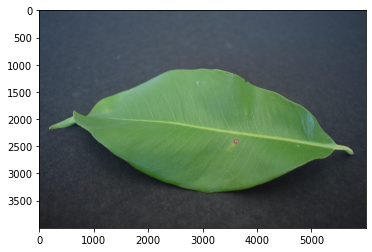

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

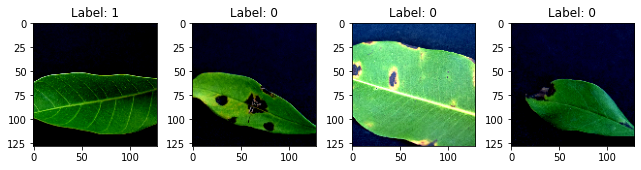

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[17:10:33] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[17:10:35] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2573443568320877 samples/sec                   batch loss = 0.4394332766532898 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.265167066715834 samples/sec                   batch loss = 0.6572290062904358 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2649385151440076 samples/sec                   batch loss = 0.5818249583244324 | accuracy = 0.6333333333333333


Epoch[1] Batch[20] Speed: 1.2687270189397626 samples/sec                   batch loss = 0.44457492232322693 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.272372965126266 samples/sec                   batch loss = 1.0489581823349 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.2623940754246858 samples/sec                   batch loss = 0.41787153482437134 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2652933014981582 samples/sec                   batch loss = 0.41177672147750854 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2656371160260547 samples/sec                   batch loss = 0.4803456962108612 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.275142624200158 samples/sec                   batch loss = 0.6671842336654663 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.2773549887276416 samples/sec                   batch loss = 0.5225803852081299 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.276319014633851 samples/sec                   batch loss = 0.385204553604126 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2729997252504823 samples/sec                   batch loss = 0.4321136176586151 | accuracy = 0.6416666666666667


Epoch[1] Batch[65] Speed: 1.2675083623726284 samples/sec                   batch loss = 0.33731985092163086 | accuracy = 0.6538461538461539


Epoch[1] Batch[70] Speed: 1.2647883227548675 samples/sec                   batch loss = 0.30152690410614014 | accuracy = 0.65


Epoch[1] Batch[75] Speed: 1.2727527899380313 samples/sec                   batch loss = 1.3805657625198364 | accuracy = 0.6533333333333333


Epoch[1] Batch[80] Speed: 1.2698804464241786 samples/sec                   batch loss = 0.42193514108657837 | accuracy = 0.671875


Epoch[1] Batch[85] Speed: 1.271344089769665 samples/sec                   batch loss = 0.7482491135597229 | accuracy = 0.6588235294117647


Epoch[1] Batch[90] Speed: 1.2646822083055618 samples/sec                   batch loss = 0.5357909202575684 | accuracy = 0.6638888888888889


Epoch[1] Batch[95] Speed: 1.2659871357985193 samples/sec                   batch loss = 0.7141989469528198 | accuracy = 0.6631578947368421


Epoch[1] Batch[100] Speed: 1.267788712359772 samples/sec                   batch loss = 0.676487147808075 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2674926580127932 samples/sec                   batch loss = 0.4474513530731201 | accuracy = 0.6571428571428571


Epoch[1] Batch[110] Speed: 1.2670049632847427 samples/sec                   batch loss = 0.2573494613170624 | accuracy = 0.6636363636363637


Epoch[1] Batch[115] Speed: 1.266436189369214 samples/sec                   batch loss = 0.8093684911727905 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.2680745536910456 samples/sec                   batch loss = 0.3206924498081207 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.270849480395371 samples/sec                   batch loss = 0.27904462814331055 | accuracy = 0.658


Epoch[1] Batch[130] Speed: 1.269841039171787 samples/sec                   batch loss = 0.8378600478172302 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.2671743455975077 samples/sec                   batch loss = 0.69832444190979 | accuracy = 0.65


Epoch[1] Batch[140] Speed: 1.2659569491139697 samples/sec                   batch loss = 0.5660408735275269 | accuracy = 0.6482142857142857


Epoch[1] Batch[145] Speed: 1.2646097594325165 samples/sec                   batch loss = 0.6450120806694031 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.267507692056636 samples/sec                   batch loss = 1.1724618673324585 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2654815077418005 samples/sec                   batch loss = 0.6249127388000488 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.2720775632048056 samples/sec                   batch loss = 0.4578922986984253 | accuracy = 0.6359375


Epoch[1] Batch[165] Speed: 1.2636510707905886 samples/sec                   batch loss = 0.34636998176574707 | accuracy = 0.6378787878787879


Epoch[1] Batch[170] Speed: 1.2711907351035368 samples/sec                   batch loss = 0.18561489880084991 | accuracy = 0.6397058823529411


Epoch[1] Batch[175] Speed: 1.271298233617612 samples/sec                   batch loss = 0.689411997795105 | accuracy = 0.6385714285714286


Epoch[1] Batch[180] Speed: 1.2719680041655903 samples/sec                   batch loss = 0.814845085144043 | accuracy = 0.6388888888888888


Epoch[1] Batch[185] Speed: 1.2694269303901147 samples/sec                   batch loss = 0.38007768988609314 | accuracy = 0.6432432432432432


Epoch[1] Batch[190] Speed: 1.2683897705458995 samples/sec                   batch loss = 0.5157809257507324 | accuracy = 0.6394736842105263


Epoch[1] Batch[195] Speed: 1.2656065641415588 samples/sec                   batch loss = 0.4154346287250519 | accuracy = 0.6423076923076924


Epoch[1] Batch[200] Speed: 1.2667455229574944 samples/sec                   batch loss = 0.5815298557281494 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2687741290477246 samples/sec                   batch loss = 0.39989519119262695 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2705795144808378 samples/sec                   batch loss = 0.24745586514472961 | accuracy = 0.6440476190476191


Epoch[1] Batch[215] Speed: 1.2649037054785375 samples/sec                   batch loss = 0.5948450565338135 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.261337171602273 samples/sec                   batch loss = 0.4924084544181824 | accuracy = 0.6443181818181818


Epoch[1] Batch[225] Speed: 1.259994681309263 samples/sec                   batch loss = 0.5713056325912476 | accuracy = 0.6477777777777778


Epoch[1] Batch[230] Speed: 1.2651594342788413 samples/sec                   batch loss = 0.5605538487434387 | accuracy = 0.6521739130434783


Epoch[1] Batch[235] Speed: 1.2713233770224348 samples/sec                   batch loss = 1.2200132608413696 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.2698971712169027 samples/sec                   batch loss = 0.7061077952384949 | accuracy = 0.65


Epoch[1] Batch[245] Speed: 1.264962930737442 samples/sec                   batch loss = 0.3794580399990082 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.2648262727654678 samples/sec                   batch loss = 0.4523155093193054 | accuracy = 0.647


Epoch[1] Batch[255] Speed: 1.2696254959493511 samples/sec                   batch loss = 0.4211500287055969 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.268826328446407 samples/sec                   batch loss = 0.7093265056610107 | accuracy = 0.6442307692307693


Epoch[1] Batch[265] Speed: 1.2675294298079767 samples/sec                   batch loss = 1.3179630041122437 | accuracy = 0.6471698113207547


Epoch[1] Batch[270] Speed: 1.2669875491397857 samples/sec                   batch loss = 0.46872422099113464 | accuracy = 0.649074074074074


Epoch[1] Batch[275] Speed: 1.2679995114595388 samples/sec                   batch loss = 0.29121899604797363 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2698235469801415 samples/sec                   batch loss = 0.6765953302383423 | accuracy = 0.6464285714285715


Epoch[1] Batch[285] Speed: 1.2715922135022604 samples/sec                   batch loss = 0.3766096234321594 | accuracy = 0.6473684210526316


Epoch[1] Batch[290] Speed: 1.2770142076562627 samples/sec                   batch loss = 0.6108407378196716 | accuracy = 0.6482758620689655


Epoch[1] Batch[295] Speed: 1.2628148236910555 samples/sec                   batch loss = 0.5090045928955078 | accuracy = 0.6466101694915254


Epoch[1] Batch[300] Speed: 1.2624815656887558 samples/sec                   batch loss = 0.3776397109031677 | accuracy = 0.6475


Epoch[1] Batch[305] Speed: 1.2653756587003657 samples/sec                   batch loss = 0.644047200679779 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.2639034368208593 samples/sec                   batch loss = 0.5715986490249634 | accuracy = 0.6483870967741936


Epoch[1] Batch[315] Speed: 1.2693257982285957 samples/sec                   batch loss = 0.2324957549571991 | accuracy = 0.65


Epoch[1] Batch[320] Speed: 1.267714087116686 samples/sec                   batch loss = 0.2313905656337738 | accuracy = 0.65


Epoch[1] Batch[325] Speed: 1.2655529109642902 samples/sec                   batch loss = 0.5780044794082642 | accuracy = 0.6523076923076923


Epoch[1] Batch[330] Speed: 1.2703431358815789 samples/sec                   batch loss = 0.37652140855789185 | accuracy = 0.656060606060606


Epoch[1] Batch[335] Speed: 1.27122666224366 samples/sec                   batch loss = 0.33456751704216003 | accuracy = 0.655223880597015


Epoch[1] Batch[340] Speed: 1.2691341427335043 samples/sec                   batch loss = 0.37047168612480164 | accuracy = 0.6558823529411765


Epoch[1] Batch[345] Speed: 1.2678735984762437 samples/sec                   batch loss = 0.38334086537361145 | accuracy = 0.6572463768115943


Epoch[1] Batch[350] Speed: 1.2613083441573503 samples/sec                   batch loss = 0.36957043409347534 | accuracy = 0.6571428571428571


Epoch[1] Batch[355] Speed: 1.2703085090418118 samples/sec                   batch loss = 0.742134690284729 | accuracy = 0.6577464788732394


Epoch[1] Batch[360] Speed: 1.2739302866818785 samples/sec                   batch loss = 1.4760980606079102 | accuracy = 0.6583333333333333


Epoch[1] Batch[365] Speed: 1.2704534734305082 samples/sec                   batch loss = 0.761992871761322 | accuracy = 0.6575342465753424


Epoch[1] Batch[370] Speed: 1.2592932196148476 samples/sec                   batch loss = 0.8016956448554993 | accuracy = 0.6574324324324324


Epoch[1] Batch[375] Speed: 1.265227461620784 samples/sec                   batch loss = 0.7793632745742798 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.2719034927504633 samples/sec                   batch loss = 0.4271419942378998 | accuracy = 0.6598684210526315


Epoch[1] Batch[385] Speed: 1.2683318539972803 samples/sec                   batch loss = 0.8092707395553589 | accuracy = 0.6597402597402597


Epoch[1] Batch[390] Speed: 1.2696031097875855 samples/sec                   batch loss = 1.0098592042922974 | accuracy = 0.6602564102564102


Epoch[1] Batch[395] Speed: 1.2636838127102645 samples/sec                   batch loss = 0.6783021688461304 | accuracy = 0.6594936708860759


Epoch[1] Batch[400] Speed: 1.2661352242480226 samples/sec                   batch loss = 0.2380959689617157 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.2625791397098038 samples/sec                   batch loss = 0.8664865493774414 | accuracy = 0.6623456790123456


Epoch[1] Batch[410] Speed: 1.270575473082012 samples/sec                   batch loss = 0.35770899057388306 | accuracy = 0.6646341463414634


Epoch[1] Batch[415] Speed: 1.2725532450524317 samples/sec                   batch loss = 0.5804854035377502 | accuracy = 0.6644578313253012


Epoch[1] Batch[420] Speed: 1.2684895068000581 samples/sec                   batch loss = 0.43195855617523193 | accuracy = 0.6672619047619047


Epoch[1] Batch[425] Speed: 1.2599354472570568 samples/sec                   batch loss = 1.2410151958465576 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.266623301401278 samples/sec                   batch loss = 0.37749800086021423 | accuracy = 0.6680232558139535


Epoch[1] Batch[435] Speed: 1.2676777835320523 samples/sec                   batch loss = 0.5991696715354919 | accuracy = 0.6689655172413793


Epoch[1] Batch[440] Speed: 1.26559883092973 samples/sec                   batch loss = 0.33850815892219543 | accuracy = 0.6681818181818182


Epoch[1] Batch[445] Speed: 1.2689895752377387 samples/sec                   batch loss = 0.6073664426803589 | accuracy = 0.6657303370786517


Epoch[1] Batch[450] Speed: 1.2618757473416862 samples/sec                   batch loss = 0.5072274208068848 | accuracy = 0.6666666666666666


Epoch[1] Batch[455] Speed: 1.2679507339803777 samples/sec                   batch loss = 0.7472703456878662 | accuracy = 0.6664835164835164


Epoch[1] Batch[460] Speed: 1.26727580527667 samples/sec                   batch loss = 0.4221113622188568 | accuracy = 0.6673913043478261


Epoch[1] Batch[465] Speed: 1.266688234643481 samples/sec                   batch loss = 1.0239756107330322 | accuracy = 0.6661290322580645


Epoch[1] Batch[470] Speed: 1.2729054594020313 samples/sec                   batch loss = 0.43291720747947693 | accuracy = 0.6664893617021277


Epoch[1] Batch[475] Speed: 1.2707298342876623 samples/sec                   batch loss = 0.5743668675422668 | accuracy = 0.6673684210526316


Epoch[1] Batch[480] Speed: 1.2682765313729791 samples/sec                   batch loss = 0.4073929488658905 | accuracy = 0.6671875


Epoch[1] Batch[485] Speed: 1.2713323364070126 samples/sec                   batch loss = 0.4338531196117401 | accuracy = 0.6675257731958762


Epoch[1] Batch[490] Speed: 1.270268979040794 samples/sec                   batch loss = 0.30224305391311646 | accuracy = 0.6673469387755102


Epoch[1] Batch[495] Speed: 1.2655295226577936 samples/sec                   batch loss = 0.3300383687019348 | accuracy = 0.6681818181818182


Epoch[1] Batch[500] Speed: 1.2608704997377886 samples/sec                   batch loss = 0.7339715361595154 | accuracy = 0.6675


Epoch[1] Batch[505] Speed: 1.2621797232915164 samples/sec                   batch loss = 0.6098029017448425 | accuracy = 0.6658415841584159


Epoch[1] Batch[510] Speed: 1.2719478496723622 samples/sec                   batch loss = 0.8011878728866577 | accuracy = 0.6637254901960784


Epoch[1] Batch[515] Speed: 1.2627059989842486 samples/sec                   batch loss = 0.31083106994628906 | accuracy = 0.6640776699029126


Epoch[1] Batch[520] Speed: 1.270132614612719 samples/sec                   batch loss = 0.4952211380004883 | accuracy = 0.6644230769230769


Epoch[1] Batch[525] Speed: 1.263305765907192 samples/sec                   batch loss = 0.9517601132392883 | accuracy = 0.6661904761904762


Epoch[1] Batch[530] Speed: 1.2589973401331471 samples/sec                   batch loss = 0.3117507994174957 | accuracy = 0.6669811320754717


Epoch[1] Batch[535] Speed: 1.2672772411434308 samples/sec                   batch loss = 0.18302111327648163 | accuracy = 0.6682242990654206


Epoch[1] Batch[540] Speed: 1.2734876001842386 samples/sec                   batch loss = 0.9505906105041504 | accuracy = 0.6680555555555555


Epoch[1] Batch[545] Speed: 1.270482239376158 samples/sec                   batch loss = 0.41700729727745056 | accuracy = 0.6688073394495413


Epoch[1] Batch[550] Speed: 1.2663310408032316 samples/sec                   batch loss = 0.43099460005760193 | accuracy = 0.6690909090909091


Epoch[1] Batch[555] Speed: 1.2684680238200061 samples/sec                   batch loss = 0.6224803924560547 | accuracy = 0.6684684684684684


Epoch[1] Batch[560] Speed: 1.2658027902077906 samples/sec                   batch loss = 0.40252894163131714 | accuracy = 0.6696428571428571


Epoch[1] Batch[565] Speed: 1.2697469522340772 samples/sec                   batch loss = 0.46123337745666504 | accuracy = 0.6694690265486726


Epoch[1] Batch[570] Speed: 1.271828767976375 samples/sec                   batch loss = 0.8790268898010254 | accuracy = 0.6710526315789473


Epoch[1] Batch[575] Speed: 1.2664134375628169 samples/sec                   batch loss = 0.3609536290168762 | accuracy = 0.6717391304347826


Epoch[1] Batch[580] Speed: 1.2636135719554156 samples/sec                   batch loss = 0.26677823066711426 | accuracy = 0.6732758620689655


Epoch[1] Batch[585] Speed: 1.2645245473034779 samples/sec                   batch loss = 0.6744651794433594 | accuracy = 0.6730769230769231


Epoch[1] Batch[590] Speed: 1.2656327241018797 samples/sec                   batch loss = 0.6348007321357727 | accuracy = 0.6733050847457627


Epoch[1] Batch[595] Speed: 1.2633244107850086 samples/sec                   batch loss = 0.39150047302246094 | accuracy = 0.6747899159663866


Epoch[1] Batch[600] Speed: 1.2573647108128376 samples/sec                   batch loss = 1.1725083589553833 | accuracy = 0.67375


Epoch[1] Batch[605] Speed: 1.2618907433453928 samples/sec                   batch loss = 0.3790653645992279 | accuracy = 0.675206611570248


Epoch[1] Batch[610] Speed: 1.259851336903054 samples/sec                   batch loss = 0.5674898624420166 | accuracy = 0.675


Epoch[1] Batch[615] Speed: 1.264910095054391 samples/sec                   batch loss = 0.39874985814094543 | accuracy = 0.6760162601626016


Epoch[1] Batch[620] Speed: 1.270159923620287 samples/sec                   batch loss = 0.2248905897140503 | accuracy = 0.6782258064516129


Epoch[1] Batch[625] Speed: 1.2644084714050814 samples/sec                   batch loss = 0.48044630885124207 | accuracy = 0.6784


Epoch[1] Batch[630] Speed: 1.2606021042624813 samples/sec                   batch loss = 1.119560718536377 | accuracy = 0.6785714285714286


Epoch[1] Batch[635] Speed: 1.269328295124978 samples/sec                   batch loss = 0.3455217182636261 | accuracy = 0.6795275590551181


Epoch[1] Batch[640] Speed: 1.272736762251555 samples/sec                   batch loss = 0.9611026048660278 | accuracy = 0.680078125


Epoch[1] Batch[645] Speed: 1.2676230926114551 samples/sec                   batch loss = 0.8776909708976746 | accuracy = 0.6810077519379845


Epoch[1] Batch[650] Speed: 1.2711435416783787 samples/sec                   batch loss = 0.548774242401123 | accuracy = 0.6823076923076923


Epoch[1] Batch[655] Speed: 1.2665739604141282 samples/sec                   batch loss = 0.8794622421264648 | accuracy = 0.6824427480916031


Epoch[1] Batch[660] Speed: 1.27003492721409 samples/sec                   batch loss = 0.23563134670257568 | accuracy = 0.6840909090909091


Epoch[1] Batch[665] Speed: 1.2674111739549867 samples/sec                   batch loss = 0.29393941164016724 | accuracy = 0.6849624060150376


Epoch[1] Batch[670] Speed: 1.2698352724619515 samples/sec                   batch loss = 0.9448835849761963 | accuracy = 0.6843283582089552


Epoch[1] Batch[675] Speed: 1.2653185896491228 samples/sec                   batch loss = 0.47902750968933105 | accuracy = 0.6844444444444444


Epoch[1] Batch[680] Speed: 1.2668512186707166 samples/sec                   batch loss = 0.5632677674293518 | accuracy = 0.6841911764705882


Epoch[1] Batch[685] Speed: 1.2614947027228296 samples/sec                   batch loss = 0.45803043246269226 | accuracy = 0.6835766423357664


Epoch[1] Batch[690] Speed: 1.2670466826340034 samples/sec                   batch loss = 0.356514036655426 | accuracy = 0.6851449275362319


Epoch[1] Batch[695] Speed: 1.2712780040139042 samples/sec                   batch loss = 0.5616536736488342 | accuracy = 0.6841726618705036


Epoch[1] Batch[700] Speed: 1.2671981775905115 samples/sec                   batch loss = 1.2074494361877441 | accuracy = 0.6839285714285714


Epoch[1] Batch[705] Speed: 1.2611596761544213 samples/sec                   batch loss = 0.46353912353515625 | accuracy = 0.6833333333333333


Epoch[1] Batch[710] Speed: 1.2669580801388056 samples/sec                   batch loss = 0.5826137065887451 | accuracy = 0.6845070422535211


Epoch[1] Batch[715] Speed: 1.2659879955669484 samples/sec                   batch loss = 0.18769338726997375 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.2750517230228422 samples/sec                   batch loss = 0.25060662627220154 | accuracy = 0.6871527777777777


Epoch[1] Batch[725] Speed: 1.265800593666944 samples/sec                   batch loss = 0.7630476355552673 | accuracy = 0.6862068965517242


Epoch[1] Batch[730] Speed: 1.2622207456252805 samples/sec                   batch loss = 0.6275866627693176 | accuracy = 0.6863013698630137


Epoch[1] Batch[735] Speed: 1.2685572213109728 samples/sec                   batch loss = 0.5585707426071167 | accuracy = 0.6857142857142857


Epoch[1] Batch[740] Speed: 1.2637522526092002 samples/sec                   batch loss = 0.7746996283531189 | accuracy = 0.6861486486486487


Epoch[1] Batch[745] Speed: 1.2672474715048605 samples/sec                   batch loss = 0.28644487261772156 | accuracy = 0.6865771812080537


Epoch[1] Batch[750] Speed: 1.2642384939350941 samples/sec                   batch loss = 0.5437734127044678 | accuracy = 0.687


Epoch[1] Batch[755] Speed: 1.2603093964520085 samples/sec                   batch loss = 0.26060470938682556 | accuracy = 0.6880794701986755


Epoch[1] Batch[760] Speed: 1.2591671396206772 samples/sec                   batch loss = 0.599269449710846 | accuracy = 0.687171052631579


Epoch[1] Batch[765] Speed: 1.2702235850915815 samples/sec                   batch loss = 0.3798019289970398 | accuracy = 0.6869281045751634


Epoch[1] Batch[770] Speed: 1.271317018826116 samples/sec                   batch loss = 0.5279870629310608 | accuracy = 0.6873376623376624


Epoch[1] Batch[775] Speed: 1.272248594038185 samples/sec                   batch loss = 0.49955904483795166 | accuracy = 0.6870967741935484


Epoch[1] Batch[780] Speed: 1.261631210927028 samples/sec                   batch loss = 0.9246435165405273 | accuracy = 0.6862179487179487


Epoch[1] Batch[785] Speed: 1.258628134751673 samples/sec                   batch loss = 0.5229189395904541 | accuracy = 0.6856687898089172


[Epoch 1] training: accuracy=0.6849619289340102
[Epoch 1] time cost: 649.2983064651489
[Epoch 1] validation: validation accuracy=0.7266666666666667


Epoch[2] Batch[5] Speed: 1.274747521256979 samples/sec                   batch loss = 0.4462253153324127 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2664970879321298 samples/sec                   batch loss = 0.29511937499046326 | accuracy = 0.875


Epoch[2] Batch[15] Speed: 1.2557570822081041 samples/sec                   batch loss = 0.29245004057884216 | accuracy = 0.8


Epoch[2] Batch[20] Speed: 1.2625654575358052 samples/sec                   batch loss = 0.19198715686798096 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.266302080219887 samples/sec                   batch loss = 0.39510950446128845 | accuracy = 0.8


Epoch[2] Batch[30] Speed: 1.265275743527527 samples/sec                   batch loss = 0.5611624121665955 | accuracy = 0.8


Epoch[2] Batch[35] Speed: 1.2680026739796761 samples/sec                   batch loss = 0.7100101709365845 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2620026551586223 samples/sec                   batch loss = 0.8474982976913452 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2613851570478358 samples/sec                   batch loss = 0.6889183521270752 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2706818089210605 samples/sec                   batch loss = 0.8446211218833923 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2640638953958967 samples/sec                   batch loss = 0.6447891592979431 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2612051830452966 samples/sec                   batch loss = 0.6190277338027954 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2614899600918048 samples/sec                   batch loss = 1.074266791343689 | accuracy = 0.7230769230769231


Epoch[2] Batch[70] Speed: 1.2671583623935623 samples/sec                   batch loss = 0.4184379279613495 | accuracy = 0.725


Epoch[2] Batch[75] Speed: 1.2707948042378572 samples/sec                   batch loss = 0.3540709614753723 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2663623923668097 samples/sec                   batch loss = 0.4614497125148773 | accuracy = 0.721875


Epoch[2] Batch[85] Speed: 1.259105148523263 samples/sec                   batch loss = 0.5935805439949036 | accuracy = 0.7294117647058823


Epoch[2] Batch[90] Speed: 1.265966883813248 samples/sec                   batch loss = 0.7478174567222595 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.271087588300508 samples/sec                   batch loss = 1.4125416278839111 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2760879694527778 samples/sec                   batch loss = 0.47740018367767334 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.275949867687596 samples/sec                   batch loss = 0.19144074618816376 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.2662173088326671 samples/sec                   batch loss = 0.4383630156517029 | accuracy = 0.7340909090909091


Epoch[2] Batch[115] Speed: 1.265944626482478 samples/sec                   batch loss = 0.7028869390487671 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.269468137002125 samples/sec                   batch loss = 0.3284619152545929 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.271859042504198 samples/sec                   batch loss = 2.270321846008301 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.269499355913489 samples/sec                   batch loss = 0.1961642950773239 | accuracy = 0.7288461538461538


Epoch[2] Batch[135] Speed: 1.265571622231923 samples/sec                   batch loss = 0.16942688822746277 | accuracy = 0.7314814814814815


Epoch[2] Batch[140] Speed: 1.2614271710185105 samples/sec                   batch loss = 0.6907100081443787 | accuracy = 0.7285714285714285


Epoch[2] Batch[145] Speed: 1.265461271930225 samples/sec                   batch loss = 0.3311001658439636 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.2688567480914263 samples/sec                   batch loss = 0.5262489318847656 | accuracy = 0.7283333333333334


Epoch[2] Batch[155] Speed: 1.2649670318866058 samples/sec                   batch loss = 0.5415368676185608 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2641258995017401 samples/sec                   batch loss = 1.0283279418945312 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2636199485038382 samples/sec                   batch loss = 0.4778275489807129 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.2672905469968614 samples/sec                   batch loss = 0.2459314912557602 | accuracy = 0.736764705882353


Epoch[2] Batch[175] Speed: 1.270649665713698 samples/sec                   batch loss = 0.1358552724123001 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.2660621311029434 samples/sec                   batch loss = 0.3917880654335022 | accuracy = 0.7361111111111112


Epoch[2] Batch[185] Speed: 1.268607196570714 samples/sec                   batch loss = 0.7826656103134155 | accuracy = 0.7351351351351352


Epoch[2] Batch[190] Speed: 1.2636550682596184 samples/sec                   batch loss = 0.315047025680542 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2620993006674213 samples/sec                   batch loss = 0.504340648651123 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2683620581598924 samples/sec                   batch loss = 0.4560023248195648 | accuracy = 0.7375


Epoch[2] Batch[205] Speed: 1.2656791272757997 samples/sec                   batch loss = 0.6491045355796814 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.2678226271195534 samples/sec                   batch loss = 0.33976036310195923 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.262571633480407 samples/sec                   batch loss = 0.8849838972091675 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2692245861607203 samples/sec                   batch loss = 0.28941670060157776 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.2623868563570935 samples/sec                   batch loss = 0.3484114408493042 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.2664725174774656 samples/sec                   batch loss = 0.10581320524215698 | accuracy = 0.7456521739130435


Epoch[2] Batch[235] Speed: 1.2659324951338775 samples/sec                   batch loss = 0.3897339105606079 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2638736350555175 samples/sec                   batch loss = 0.3621711730957031 | accuracy = 0.74375


Epoch[2] Batch[245] Speed: 1.265657357461862 samples/sec                   batch loss = 0.7423467636108398 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2724354010527927 samples/sec                   batch loss = 0.6514158844947815 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2692980449263835 samples/sec                   batch loss = 0.18592672049999237 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.270669586611676 samples/sec                   batch loss = 0.35735753178596497 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2674856677826623 samples/sec                   batch loss = 0.5974166989326477 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2675763552492452 samples/sec                   batch loss = 0.19964653253555298 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2721321568834112 samples/sec                   batch loss = 0.3371451497077942 | accuracy = 0.7427272727272727


Epoch[2] Batch[280] Speed: 1.2742507445882068 samples/sec                   batch loss = 0.6698818802833557 | accuracy = 0.7410714285714286


Epoch[2] Batch[285] Speed: 1.2714784981786724 samples/sec                   batch loss = 0.4394145607948303 | accuracy = 0.7394736842105263


Epoch[2] Batch[290] Speed: 1.2717708261635905 samples/sec                   batch loss = 0.14393989741802216 | accuracy = 0.7422413793103448


Epoch[2] Batch[295] Speed: 1.2697285977766224 samples/sec                   batch loss = 0.9899915456771851 | accuracy = 0.7406779661016949


Epoch[2] Batch[300] Speed: 1.2675924447718132 samples/sec                   batch loss = 0.36819544434547424 | accuracy = 0.7425


Epoch[2] Batch[305] Speed: 1.2690399685334786 samples/sec                   batch loss = 0.9021100997924805 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2655788777702803 samples/sec                   batch loss = 0.27851641178131104 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2675228222187838 samples/sec                   batch loss = 0.1873112916946411 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2637146525816183 samples/sec                   batch loss = 0.19804003834724426 | accuracy = 0.74453125


Epoch[2] Batch[325] Speed: 1.2611793005983702 samples/sec                   batch loss = 0.7315117716789246 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.269842096407605 samples/sec                   batch loss = 0.5743551850318909 | accuracy = 0.7431818181818182


Epoch[2] Batch[335] Speed: 1.269068478513367 samples/sec                   batch loss = 0.4216177761554718 | accuracy = 0.7455223880597015


Epoch[2] Batch[340] Speed: 1.2745189810634154 samples/sec                   batch loss = 0.22593264281749725 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2682868860204486 samples/sec                   batch loss = 0.22056888043880463 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2684441440399317 samples/sec                   batch loss = 0.36721184849739075 | accuracy = 0.75


Epoch[2] Batch[355] Speed: 1.2701282875890145 samples/sec                   batch loss = 0.6778016090393066 | accuracy = 0.75


Epoch[2] Batch[360] Speed: 1.2689848720676706 samples/sec                   batch loss = 0.20456571877002716 | accuracy = 0.7520833333333333


Epoch[2] Batch[365] Speed: 1.2680953524076042 samples/sec                   batch loss = 0.3557957410812378 | accuracy = 0.7527397260273972


Epoch[2] Batch[370] Speed: 1.2619330757599896 samples/sec                   batch loss = 0.9260472059249878 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.2618878959755042 samples/sec                   batch loss = 0.5247054696083069 | accuracy = 0.7506666666666667


Epoch[2] Batch[380] Speed: 1.267129938170716 samples/sec                   batch loss = 0.6019795536994934 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.267937126787319 samples/sec                   batch loss = 0.26029670238494873 | accuracy = 0.7538961038961038


Epoch[2] Batch[390] Speed: 1.2728408528629485 samples/sec                   batch loss = 0.23886491358280182 | accuracy = 0.7544871794871795


Epoch[2] Batch[395] Speed: 1.268019253510041 samples/sec                   batch loss = 0.4092673361301422 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.2671237175512842 samples/sec                   batch loss = 0.18098071217536926 | accuracy = 0.756875


Epoch[2] Batch[405] Speed: 1.271958650086914 samples/sec                   batch loss = 0.6572589874267578 | accuracy = 0.7561728395061729


Epoch[2] Batch[410] Speed: 1.27567918568052 samples/sec                   batch loss = 0.3658076822757721 | accuracy = 0.7560975609756098


Epoch[2] Batch[415] Speed: 1.271993463385794 samples/sec                   batch loss = 0.2573529779911041 | accuracy = 0.755421686746988


Epoch[2] Batch[420] Speed: 1.2671326178409854 samples/sec                   batch loss = 0.786354660987854 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2645238801397236 samples/sec                   batch loss = 0.43789660930633545 | accuracy = 0.7523529411764706


Epoch[2] Batch[430] Speed: 1.2684616941521698 samples/sec                   batch loss = 0.741740345954895 | accuracy = 0.7511627906976744


Epoch[2] Batch[435] Speed: 1.2748122246360882 samples/sec                   batch loss = 0.6995426416397095 | accuracy = 0.75


Epoch[2] Batch[440] Speed: 1.2817075483099813 samples/sec                   batch loss = 0.21736936271190643 | accuracy = 0.7517045454545455


Epoch[2] Batch[445] Speed: 1.2734484520365768 samples/sec                   batch loss = 0.46101585030555725 | accuracy = 0.75


Epoch[2] Batch[450] Speed: 1.2695123242203594 samples/sec                   batch loss = 0.37570345401763916 | accuracy = 0.7511111111111111


Epoch[2] Batch[455] Speed: 1.2675910081906918 samples/sec                   batch loss = 0.3421356976032257 | accuracy = 0.7510989010989011


Epoch[2] Batch[460] Speed: 1.2729323082934527 samples/sec                   batch loss = 1.3191317319869995 | accuracy = 0.7510869565217392


Epoch[2] Batch[465] Speed: 1.2672315821738154 samples/sec                   batch loss = 0.4536493718624115 | accuracy = 0.75


Epoch[2] Batch[470] Speed: 1.2742243239357494 samples/sec                   batch loss = 0.4530165493488312 | accuracy = 0.749468085106383


Epoch[2] Batch[475] Speed: 1.2624733956176626 samples/sec                   batch loss = 0.6987999677658081 | accuracy = 0.7473684210526316


Epoch[2] Batch[480] Speed: 1.2733791512179942 samples/sec                   batch loss = 0.8141465783119202 | accuracy = 0.7473958333333334


Epoch[2] Batch[485] Speed: 1.2739270945245986 samples/sec                   batch loss = 0.3935600519180298 | accuracy = 0.7474226804123711


Epoch[2] Batch[490] Speed: 1.2754634984714326 samples/sec                   batch loss = 0.7534857392311096 | accuracy = 0.7479591836734694


Epoch[2] Batch[495] Speed: 1.2786279371691678 samples/sec                   batch loss = 0.569057285785675 | accuracy = 0.7484848484848485


Epoch[2] Batch[500] Speed: 1.2648690884510352 samples/sec                   batch loss = 0.6072584390640259 | accuracy = 0.749


Epoch[2] Batch[505] Speed: 1.274073369794484 samples/sec                   batch loss = 0.4462979733943939 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.2735855294246696 samples/sec                   batch loss = 0.5082136392593384 | accuracy = 0.7465686274509804


Epoch[2] Batch[515] Speed: 1.2747509112410353 samples/sec                   batch loss = 0.7541159391403198 | accuracy = 0.7451456310679612


Epoch[2] Batch[520] Speed: 1.2674230464206129 samples/sec                   batch loss = 0.34345564246177673 | accuracy = 0.7442307692307693


Epoch[2] Batch[525] Speed: 1.2649600694863319 samples/sec                   batch loss = 0.34746360778808594 | accuracy = 0.7447619047619047


Epoch[2] Batch[530] Speed: 1.263453322827409 samples/sec                   batch loss = 0.24369467794895172 | accuracy = 0.7462264150943396


Epoch[2] Batch[535] Speed: 1.2684246764507823 samples/sec                   batch loss = 0.6121426224708557 | accuracy = 0.747196261682243


Epoch[2] Batch[540] Speed: 1.26804915526203 samples/sec                   batch loss = 0.7583520412445068 | accuracy = 0.7481481481481481


Epoch[2] Batch[545] Speed: 1.2709127296364746 samples/sec                   batch loss = 0.3243328630924225 | accuracy = 0.7477064220183486


Epoch[2] Batch[550] Speed: 1.2703584300034854 samples/sec                   batch loss = 0.10342095047235489 | accuracy = 0.7490909090909091


Epoch[2] Batch[555] Speed: 1.2666372629209757 samples/sec                   batch loss = 0.9872509241104126 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2711073303240923 samples/sec                   batch loss = 0.33601436018943787 | accuracy = 0.75


Epoch[2] Batch[565] Speed: 1.2688174043477745 samples/sec                   batch loss = 0.3096723258495331 | accuracy = 0.7504424778761062


Epoch[2] Batch[570] Speed: 1.2696898725732735 samples/sec                   batch loss = 0.44541436433792114 | accuracy = 0.7521929824561403


Epoch[2] Batch[575] Speed: 1.2662427295002379 samples/sec                   batch loss = 0.638134777545929 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.2659293429317466 samples/sec                   batch loss = 0.14885887503623962 | accuracy = 0.7521551724137931


Epoch[2] Batch[585] Speed: 1.264411901914191 samples/sec                   batch loss = 0.18365038931369781 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.266380554043606 samples/sec                   batch loss = 0.4501992166042328 | accuracy = 0.7529661016949153


Epoch[2] Batch[595] Speed: 1.266163412748336 samples/sec                   batch loss = 0.280852347612381 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.2620643622722765 samples/sec                   batch loss = 0.39380350708961487 | accuracy = 0.7541666666666667


Epoch[2] Batch[605] Speed: 1.265648573363031 samples/sec                   batch loss = 0.6438589692115784 | accuracy = 0.753305785123967


Epoch[2] Batch[610] Speed: 1.2716031042572271 samples/sec                   batch loss = 0.2979587912559509 | accuracy = 0.7549180327868853


Epoch[2] Batch[615] Speed: 1.2628407733119724 samples/sec                   batch loss = 0.5780767798423767 | accuracy = 0.7556910569105691


Epoch[2] Batch[620] Speed: 1.2692705809155063 samples/sec                   batch loss = 0.8762078285217285 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2611438443186567 samples/sec                   batch loss = 0.39547449350357056 | accuracy = 0.7556


Epoch[2] Batch[630] Speed: 1.2714029561916875 samples/sec                   batch loss = 0.7402421236038208 | accuracy = 0.7543650793650793


Epoch[2] Batch[635] Speed: 1.2671690816235357 samples/sec                   batch loss = 0.4773499369621277 | accuracy = 0.7559055118110236


Epoch[2] Batch[640] Speed: 1.2649010352271572 samples/sec                   batch loss = 0.49583959579467773 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.2685777481004659 samples/sec                   batch loss = 0.6671996712684631 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.271923549410224 samples/sec                   batch loss = 0.5344663858413696 | accuracy = 0.7561538461538462


Epoch[2] Batch[655] Speed: 1.2662147285964012 samples/sec                   batch loss = 0.23271653056144714 | accuracy = 0.7572519083969466


Epoch[2] Batch[660] Speed: 1.2737734062435275 samples/sec                   batch loss = 0.24922612309455872 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.280791113651743 samples/sec                   batch loss = 0.29137420654296875 | accuracy = 0.7590225563909775


Epoch[2] Batch[670] Speed: 1.27075466646206 samples/sec                   batch loss = 0.5315439105033875 | accuracy = 0.7585820895522388


Epoch[2] Batch[675] Speed: 1.272024999514761 samples/sec                   batch loss = 0.9123216867446899 | accuracy = 0.7592592592592593


Epoch[2] Batch[680] Speed: 1.2653286097621292 samples/sec                   batch loss = 0.740344762802124 | accuracy = 0.7584558823529411


Epoch[2] Batch[685] Speed: 1.2698500737891696 samples/sec                   batch loss = 0.46818897128105164 | accuracy = 0.7583941605839416


Epoch[2] Batch[690] Speed: 1.2734860535450838 samples/sec                   batch loss = 0.49145564436912537 | accuracy = 0.7583333333333333


Epoch[2] Batch[695] Speed: 1.2732332285536918 samples/sec                   batch loss = 0.4829881489276886 | accuracy = 0.758273381294964


Epoch[2] Batch[700] Speed: 1.2669320567063544 samples/sec                   batch loss = 0.7833938002586365 | accuracy = 0.7571428571428571


Epoch[2] Batch[705] Speed: 1.2648721400136702 samples/sec                   batch loss = 0.6288931369781494 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.263433912985263 samples/sec                   batch loss = 0.43343719840049744 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2702285859608575 samples/sec                   batch loss = 0.16916419565677643 | accuracy = 0.7580419580419581


Epoch[2] Batch[720] Speed: 1.2702985060839829 samples/sec                   batch loss = 0.6969031691551208 | accuracy = 0.7579861111111111


Epoch[2] Batch[725] Speed: 1.2666683427514955 samples/sec                   batch loss = 0.380952388048172 | accuracy = 0.7575862068965518


Epoch[2] Batch[730] Speed: 1.2638624002499819 samples/sec                   batch loss = 0.17572154104709625 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2630915795480724 samples/sec                   batch loss = 0.615558385848999 | accuracy = 0.7571428571428571


Epoch[2] Batch[740] Speed: 1.2696206919854494 samples/sec                   batch loss = 0.7245309948921204 | accuracy = 0.7567567567567568


Epoch[2] Batch[745] Speed: 1.2684600637934127 samples/sec                   batch loss = 0.5572028160095215 | accuracy = 0.7567114093959731


Epoch[2] Batch[750] Speed: 1.2718826653501987 samples/sec                   batch loss = 0.4377141296863556 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.262225778641537 samples/sec                   batch loss = 0.7218964695930481 | accuracy = 0.7546357615894039


Epoch[2] Batch[760] Speed: 1.262214763035527 samples/sec                   batch loss = 0.20942027866840363 | accuracy = 0.7546052631578948


Epoch[2] Batch[765] Speed: 1.2717716938057093 samples/sec                   batch loss = 1.0997802019119263 | accuracy = 0.7542483660130719


Epoch[2] Batch[770] Speed: 1.26909074982653 samples/sec                   batch loss = 0.6797736883163452 | accuracy = 0.7548701298701299


Epoch[2] Batch[775] Speed: 1.2721445038067165 samples/sec                   batch loss = 0.1887982040643692 | accuracy = 0.7558064516129033


Epoch[2] Batch[780] Speed: 1.2656445632714932 samples/sec                   batch loss = 0.3509953022003174 | accuracy = 0.7560897435897436


Epoch[2] Batch[785] Speed: 1.263019217715075 samples/sec                   batch loss = 0.19121773540973663 | accuracy = 0.7563694267515924


[Epoch 2] training: accuracy=0.7566624365482234
[Epoch 2] time cost: 639.5290982723236
[Epoch 2] validation: validation accuracy=0.7566666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)